**Homework 13**

In [169]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

*Background*

Recall that Logistic Regression is a technique to predict either `True` or `False` for each observation. The key idea is to use a linear model to create a number $t_i$ for each observation $x_i$, and then turn these numbers into *probabilities* of `True` with the sigmoid function:

$$\sigma(t_i)=\frac{1}{1+e^{-t_i}}$$

Your model should predict `True` when this probability value is above 0.5, and `False` otherwise. 

To create the model, we seek a local minimum for the negative of the "Log Loss". The Log Loss is the log of the probability that our predictions are all correct. If $y_i$ is the target truth value for the observation $x_i$, then the Log Loss is given by:

$$\log \left(\prod \limits _{y_i=T} \sigma(t_i) * \prod \limits _{y_i=F} (1-\sigma(t_i))\right)\\
=\sum \limits _{y_i=T} \log(\sigma(t_i)) + \sum \limits _{y_i=F} \log(1-\sigma(t_i))\\
=\sum \limits _i  y_i \log(\sigma(t_i)) +  (1-y_i)\log(1-\sigma(t_i))$$

As in the case of RSS vs MSE, the negative *Mean* Log Loss is obtained from the negative of the Log Loss by dividing by the number of rows in our dataset, to account for datasets of varying size. 

To find the minimum of the negative mean Log Loss, we use gradient descent. To find the gradient we need to compute the partial derivative with respect to the coefficients and intercept of our model. As discussed in class, the derivative with respect to $c_j$, the coefficent of the column $X^j$ of the feature matrix, is

$$\frac{\partial logloss}{\partial c_j}= \frac{1}{len(y)}\sum \limits_i (\sigma(t_i)-y_i)X^j_i$$

If we call the quantity $\sigma(t_i)-y_i$ the "$i$th residual", then we can express this in vector form as:
$$\frac{\partial LogLoss}{\partial coeffs}= \frac{1}{len(y)}X^T\cdot residuals$$


Similarly, the derivative with respect to the intercept $b$ is
$$\frac{\partial LogLoss}{\partial b}= \frac{1}{len(y)}\sum \limits _i (\sigma(t_i)-y_i)$$
$$=mean(residuals)$$

These gradients should look very familiar!! The only thing that has changed from Linear Regression is the definition of the residuals. 


With this background, you should now be prepared to create the `LogisticRegression` class. We begin with a solution to the last assignment. Your task is to modify this code to perform logistic regression.

In [170]:
class LogisticRegression():
    def __init__(self,learning_rate, max_iter, batch_size, penalty='l2', alpha=0.0001):
        self.lr=learning_rate
        self.max_iter=max_iter #number of epochs
        self.batch_size=batch_size
        self.penalty=penalty #either 'l1' or 'l2'
        self.alpha=alpha #amount of regularization to apply
        
    def fit(self,X,y):
        self.coef=np.ones((X.shape[1],)) #Initial values
        self.intercept=1 #Initial value
        if self.penalty=='l1':
            penalty_grad=lambda x:2*(x>0)-1
        elif self.penalty=='l2':
            penalty_grad=lambda x:x
        indices=np.arange(len(X))
        for i in range(self.max_iter):
            np.random.seed(i) #Just so everyone gets the same answer!
            np.random.shuffle(indices)
            X_shuffle=X[indices] 
            y_shuffle=y[indices] 
            for j in range(0,len(X),self.batch_size):
                X_batch=X_shuffle[j:j+self.batch_size]
                y_batch=y_shuffle[j:j+self.batch_size]
                sig_res = 1/(1 + np.exp(-self.predict_proba(X_batch)))
                residuals= sig_res - y_batch        # sigmoid(T_i) - y_i label, where T is the 
                coef_grad=(X_batch.T)@residuals/len(X_batch)
                intercept_grad=np.mean(residuals)
                self.coef-=self.lr*coef_grad+self.alpha*penalty_grad(self.coef)
                self.intercept-=self.lr*intercept_grad+self.alpha*penalty_grad(self.intercept)
            
    def predict_proba(self,X):
        '''returns the predicted probabilites that each x in X
        is in the "True" class'''
        return X@self.coef + self.intercept
        # T = X @ self.coef + self.intercept
        # print(1. / (1. + np.exp(-T)))
        # return 1. / (1. + np.exp(-T))
    
    def predict(self,X):
        '''returns a prediction, for each x in X, that the class
        is "True".'''
        pred = X@self.coef + self.intercept
        # # print(pred > 0.5)
        return pred > 0.5
        # probs = self.predict_proba(X)
        # return probs > 0.5
    
    def score(self,X,y): 
        '''returns accuracy of the model'''
        predictions = self.predict(X)
        return np.sum((predictions == y))/X.shape[0]


    def NegLogLoss(self,X,y): #Not a sklearn method!
        '''returns the negative of the mean Log Loss'''
        T = self.predict_proba(X)
        # print(T)
        sig_res = 1. /(1. + np.exp(-T))
        return  -np.mean(y * np.log(sig_res) + (1-y)*(np.log(1-sig_res)))

We're now ready to test your code. We import the iris dataset, construct a feature matrix from the Petal Length and Petal Width columns, and target truth values depending on whether the species is virginica:

In [171]:
iris=(pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv',index_col=0))
X=np.array(iris[['Petal.Length','Petal.Width']])
y=np.array(iris['Species']=='virginica')

Now, create a Logistic Regression model which will train for 2000 epochs, using batches of size 10, and a learning rate of 0.01. Do not use any regularization.

In [172]:
log_mod= LogisticRegression(batch_size=10, learning_rate=0.01, max_iter=2000, alpha=0)

Fit your model to `X` and `y`.

In [173]:
log_mod.fit(X, y)

Check the accuracy of your model:

In [174]:
accuracy= log_mod.score(X,y)
accuracy

0.96

Check the negative of the mean Log Loss:

In [175]:
neglogloss= log_mod.NegLogLoss(X,y)
neglogloss

0.17181907559926746

To see the "decision boundary" between where your model will predict virginica (in blue) vs the other species, run the following code block:

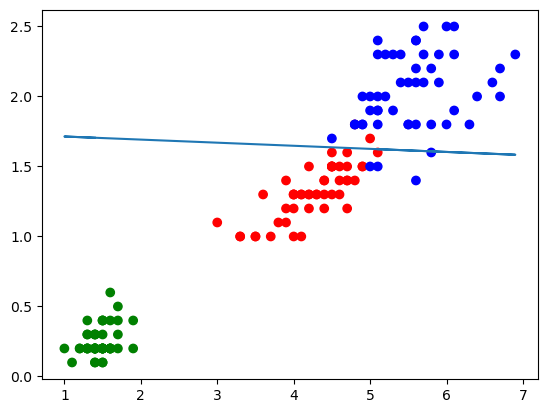

In [176]:
def func(x):
  m=-log_mod.coef[0]/log_mod.coef[1]
  b=-log_mod.intercept/log_mod.coef[1]
  return m*x+b

cdict={'versicolor':'r','setosa':'g','virginica':'b'}
colors=iris.apply(lambda x:cdict[x.Species],axis=1)

plt.scatter(X[:,0],X[:,1],c=colors)
plt.plot(X[:,0],func(X[:,0]))